The following file has been adapted from a Kaggle Kernel and can be found at the link

https://www.kaggle.com/hendraherviawan/predicting-german-credit-default#

In [39]:
#Importing necessary packages in Python 
%matplotlib inline 
import matplotlib.pyplot as plt 

import numpy as np ; np.random.seed(sum(map(ord, "aesthetics")))
import pandas as pd
from collections import defaultdict


from sklearn.datasets import make_classification 
from sklearn.model_selection import learning_curve
#from sklearn.cross_validation import train_test_split 
#from sklearn.grid_search import GridSearchCV
#from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import ShuffleSplit,train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler

import seaborn 
seaborn.set_context('notebook') 
seaborn.set_style(style='darkgrid')

from pprint import pprint 
 


### Evaluation Function


In [2]:
# Function for evaluation reports
def get_eval1(clf, X,y):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X, y, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X, y, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X, y, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X, y, cv=2, scoring='roc_auc')
    
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    
    return 

def get_eval2(clf, X_train, y_train,X_test, y_test):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X_test, y_test, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X_test, y_test, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X_test, y_test, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X_test, y_test, cv=2, scoring='roc_auc')
    
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    
    return  
  
# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="upper left")
    plt.show()
    return


#### XGBoost Model

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import xgboost as xgb
from xgboost import XGBClassifier
#print('XGBoost v',xgb.__version__)

# fit, train and cross validate Decision Tree with training and test data 
def xgbclf(params, X_train, y_train,X_test, y_test):
  
    eval_set=[(X_train, y_train), (X_test, y_test)]
    
    model = XGBClassifier(**params).\
      fit(X_train, y_train, eval_set=eval_set, \
                  eval_metric='auc', early_stopping_rounds = 100, verbose=100)
        
    #print(model.best_ntree_limit)

    model.set_params(**{'n_estimators': model.best_ntree_limit})
    model.fit(X_train, y_train)
    #print(model,'\n')
    
    # Predict target variables y for test data
    y_pred = model.predict(X_test, ntree_limit=model.best_ntree_limit) #model.best_iteration
    #print(y_pred)
   
    # Get Cross Validation and Confusion matrix
    #get_eval(model, X_train, y_train)
    #get_eval2(model, X_train, y_train,X_test, y_test)
    
    # Create and print confusion matrix    
    abclf_cm = confusion_matrix(y_test,y_pred)
    print(abclf_cm)
    
    #y_pred = model.predict(X_test)
    print (classification_report(y_test,y_pred) )
    print ('\n')
    print ("Model Final Generalization Accuracy: %.6f" %accuracy_score(y_test,y_pred) )
    
    # Predict probabilities target variables y for test data
    y_pred_proba = model.predict_proba(X_test, ntree_limit=model.best_ntree_limit)[:,1] #model.best_iteration
    get_roc (y_test,y_pred_proba)
    return model

def plot_featureImportance(model, keys):
  importances = model.feature_importances_

  importance_frame = pd.DataFrame({'Importance': list(importances), 'Feature': list(keys)})
  importance_frame.sort_values(by = 'Importance', inplace = True)
  importance_frame.tail(10).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

<a id="Preprocess"></a> <br>
# **2. Preprocess** 
- Importing Dataset
- StandardScaler
- Encoding Categorical Feature
- Concate Transformed Dataset
- Split Training Dataset
- XGBoost  1a: Unbalance Dataset (Base Model: ROC_AUC:0.74)
- XGBoost  1b: Unbalance Dataset (ROC_AUC:0.79)

### Import Dataset

OK let's get started. We'll download the data from the UCI website.

In [52]:
# file = 'GermanData.csv'
file = 'german.data'

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']

data = pd.read_csv(file,names = names, sep = " ")
print(data.shape)
print (data.columns)
data.head(10)

(1000, 21)
Index(['existingchecking', 'duration', 'credithistory', 'purpose',
       'creditamount', 'savings', 'employmentsince', 'installmentrate',
       'statussex', 'otherdebtors', 'residencesince', 'property', 'age',
       'otherinstallmentplans', 'housing', 'existingcredits', 'job',
       'peopleliable', 'telephone', 'foreignworker', 'classification'],
      dtype='object')


,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,...,A122,53,A143,A152,1,A173,1,A191,A201,1
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,1
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,...,A121,61,A143,A152,1,A172,1,A191,A201,1
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2


In [53]:
# Binarize the y output for easier use of e.g. ROC curves -> 0 = 'bad' credit; 1 = 'good' credit
data.classification.replace([1,2], [1,0], inplace=True)
# Print number of 'good' credits (should be 700) and 'bad credits (should be 300)
data.classification.value_counts()

1    700
0    300
Name: classification, dtype: int64

### StandardScaler

In [54]:
#numerical variables labels
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable', 'classification']

# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(data[numvars].drop(['classification'], axis=1)))

### Encoding Categorical Feature

Labelencoding to transform categorical to numerical, Enables better Visualization than one hot encoding

In [55]:
from collections import defaultdict

#categorical variables labels
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
           'telephone', 'foreignworker']

d = defaultdict(LabelEncoder)

# Encoding the variable
lecatdata = data[catvars].apply(lambda x: d[x.name].fit_transform(x))

# print transformations
for x in range(len(catvars)):
    print(catvars[x],": ", data[catvars[x]].unique())
    print(catvars[x],": ", lecatdata[catvars[x]].unique())

#One hot encoding, create dummy variables for every category of every categorical variable
dummyvars = pd.get_dummies(data[catvars])

existingchecking :  ['A11' 'A12' 'A14' 'A13']
existingchecking :  [0 1 3 2]
credithistory :  ['A34' 'A32' 'A33' 'A30' 'A31']
credithistory :  [4 2 3 0 1]
purpose :  ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
purpose :  [4 7 3 0 1 9 5 6 2 8]
savings :  ['A65' 'A61' 'A63' 'A64' 'A62']
savings :  [4 0 2 3 1]
employmentsince :  ['A75' 'A73' 'A74' 'A71' 'A72']
employmentsince :  [4 2 3 0 1]
statussex :  ['A93' 'A92' 'A91' 'A94']
statussex :  [2 1 0 3]
otherdebtors :  ['A101' 'A103' 'A102']
otherdebtors :  [0 2 1]
property :  ['A121' 'A122' 'A124' 'A123']
property :  [0 1 3 2]
otherinstallmentplans :  ['A143' 'A141' 'A142']
otherinstallmentplans :  [2 0 1]
housing :  ['A152' 'A153' 'A151']
housing :  [1 2 0]
job :  ['A173' 'A172' 'A174' 'A171']
job :  [2 1 3 0]
telephone :  ['A192' 'A191']
telephone :  [1 0]
foreignworker :  ['A201' 'A202']
foreignworker :  [0 1]


### Concate Transformed Dataset
append the dummy variable of the initial numerical variables numvars# append 

In [56]:
data_clean = pd.concat([data[numvars], dummyvars], axis = 1)

print(data_clean.shape)

(1000, 62)


### Split Training Dataset

In [57]:
# Unscaled, unnormalized data
X_clean = data_clean.drop('classification', axis=1)
y_clean = data_clean['classification']
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean,y_clean,test_size=0.2, random_state=1)

In [58]:
X_train_clean.keys()

Index(['creditamount', 'duration', 'installmentrate', 'residencesince', 'age',
       'existingcredits', 'peopleliable', 'existingchecking_A11',
       'existingchecking_A12', 'existingchecking_A13', 'existingchecking_A14',
       'credithistory_A30', 'credithistory_A31', 'credithistory_A32',
       'credithistory_A33', 'credithistory_A34', 'purpose_A40', 'purpose_A41',
       'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44',
       'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49',
       'savings_A61', 'savings_A62', 'savings_A63', 'savings_A64',
       'savings_A65', 'employmentsince_A71', 'employmentsince_A72',
       'employmentsince_A73', 'employmentsince_A74', 'employmentsince_A75',
       'statussex_A91', 'statussex_A92', 'statussex_A93', 'statussex_A94',
       'otherdebtors_A101', 'otherdebtors_A102', 'otherdebtors_A103',
       'property_A121', 'property_A122', 'property_A123', 'property_A124',
       'otherinstallmentplans_A141', 'otherinstallmentplans_A

### XGBoost  1a: Unbalance Dataset (Base Model: ROC_AUC:0.74)

[0]	validation_0-auc:0.761589	validation_1-auc:0.692451
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[99]	validation_0-auc:0.947201	validation_1-auc:0.735064
[[ 24  35]
 [ 13 128]]
              precision    recall  f1-score   support

           0       0.65      0.41      0.50        59
           1       0.79      0.91      0.84       141

    accuracy                           0.76       200
   macro avg       0.72      0.66      0.67       200
weighted avg       0.74      0.76      0.74       200



Model Final Generalization Accuracy: 0.760000


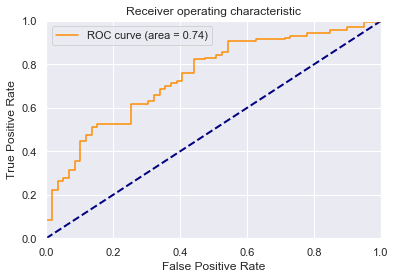

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=51,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [59]:
params={}
xgbclf(params, X_train_clean, y_train_clean, X_test_clean, y_test_clean)

### XGBoost  1b: Unbalance Dataset (ROC_AUC:0.79)

[0]	validation_0-auc:0.716102	validation_1-auc:0.621529
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.895033	validation_1-auc:0.781945
Stopping. Best iteration:
[44]	validation_0-auc:0.886052	validation_1-auc:0.789398

[[ 20  39]
 [ 10 131]]
              precision    recall  f1-score   support

           0       0.67      0.34      0.45        59
           1       0.77      0.93      0.84       141

    accuracy                           0.76       200
   macro avg       0.72      0.63      0.65       200
weighted avg       0.74      0.76      0.73       200



Model Final Generalization Accuracy: 0.755000


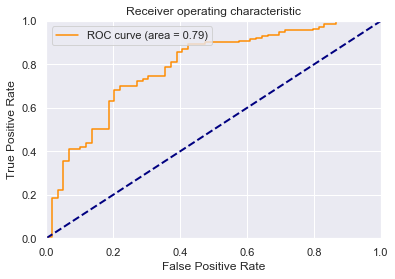

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.7, gamma=0, learning_rate=0.005,
              max_delta_step=0, max_depth=8, min_child_weight=3, missing=None,
              n_estimators=45, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.555)

In [60]:
params={}

params1={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':3,
    'max_depth':3,
    #'seed':1024,
    'n_jobs' : -1
}

params2={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.005,
    #'gamma':0.01,
    'subsample':0.555,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'max_depth':8,
    #'seed':1024,
    'n_jobs' : -1
}

xgbclf(params2, X_train_clean, y_train_clean, X_test_clean, y_test_clean)

<a id="Balanced Dataset"></a> <br>
# **3. Balanced Dataset** 
- XGBoost 2a: Balanced (Base Model: ROC_AUC:0.77)
- XGBoost 2b: Balanced (ROC_AUC:0.80)

In [61]:

from imblearn.over_sampling import SMOTE

# Oversampling
# http://contrib.scikit-learn.org/imbalanced-learn/auto_examples/combine/plot_smote_enn.html#sphx-glr-auto-examples-combine-plot-smote-enn-py

# Apply SMOTE
sm = SMOTE(sampling_strategy='auto')
X_train_clean_res, y_train_clean_res = sm.fit_sample(X_train_clean, y_train_clean)

# Print number of 'good' credits and 'bad credits, should be fairly balanced now
print("Before/After clean")
unique, counts = np.unique(y_train_clean, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_clean_res, return_counts=True)
print(dict(zip(unique, counts)))

Before/After clean
{0: 241, 1: 559}
{0: 559, 1: 559}


In [62]:
#Great, before we do anything else, let's split the data into train/test.
X_train_clean_res = pd.DataFrame(X_train_clean_res, columns=X_train_clean.keys())
#y_train_clean_res = pd.DataFrame(y_train_clean_res)

In [63]:
print(np.shape(X_train_clean_res))
print(np.shape(y_train_clean_res))
print(np.shape(X_test_clean)) 
print(np.shape(y_test_clean))

(1118, 61)
(1118,)
(200, 61)
(200,)


### XGBoost 2a: Balanced (Base Model: ROC_AUC:0.77)

[0]	validation_0-auc:0.817006	validation_1-auc:0.690468
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[99]	validation_0-auc:0.973355	validation_1-auc:0.754297
[[ 31  28]
 [ 27 114]]
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        59
           1       0.80      0.81      0.81       141

    accuracy                           0.73       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.72      0.72      0.72       200



Model Final Generalization Accuracy: 0.725000


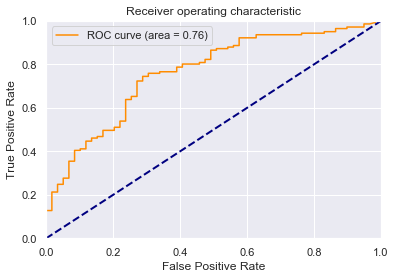

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=32,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [64]:
#BASE MODEL
params={}
xgbclf(params,X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### XGBoost 2b: Balanced (ROC_AUC:0.80)

[0]	validation_0-auc:0.893928	validation_1-auc:0.661919
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.950519	validation_1-auc:0.786393
Stopping. Best iteration:
[55]	validation_0-auc:0.944515	validation_1-auc:0.788316

[[ 33  26]
 [ 17 124]]
              precision    recall  f1-score   support

           0       0.66      0.56      0.61        59
           1       0.83      0.88      0.85       141

    accuracy                           0.79       200
   macro avg       0.74      0.72      0.73       200
weighted avg       0.78      0.79      0.78       200



Model Final Generalization Accuracy: 0.785000


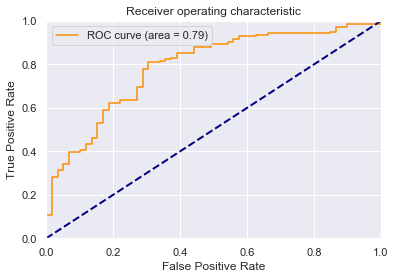

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.7, gamma=0, learning_rate=0.005,
              max_delta_step=0, max_depth=8, min_child_weight=3, missing=None,
              n_estimators=56, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.555)

In [65]:
params = {}

params1={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':3,
    'max_depth':3,
    #'seed':1024,
    'n_jobs' : -1
}

params2={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.005,
    #'gamma':0.01,
    'subsample':0.555,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'max_depth':8,
    #'seed':1024,
    'n_jobs' : -1
}

#xgbclf(params, X_train, y_train,X_test,y_test)
model = xgbclf(params2,X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)
model
#plot_featureImportance(model, X_train_clean_res.keys())

# 4.  Feature Selection
- XGBoost3 (Base Model:ROC_AUC:0.73)
- GridSearchCV (ROC_AUC:0.70)

In [67]:
#model = xgbclf(params1,X_train_clean_res[importance_col], y_train_clean_res,X_test_clean[importance_col], y_test_clean)

importances = model.feature_importances_
importance_frame = pd.DataFrame({'Importance': list(importances), 'Feature': list(X_train_clean_res.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True, ascending=False)
importance_col = importance_frame.Feature.head(10).values


In [111]:
importance_frame['parent'] = importance_frame['Feature'].apply(lambda x: x.split("_")[0])
total = importance_frame.groupby("parent")['Importance'].sum().reset_index()
total.sort_values('Importance', ascending = False, inplace = True)
topfeatures = list(total.parent[:10])
topfeatures.append('classification')
topfeatures.append('job')
topfeatures.remove('otherinstallmentplans')
total

,parent,Importance
1,creditamount,0.136060
5,existingchecking,0.100167
2,credithistory,0.096828
3,duration,0.096828
0,age,0.091820
18,statussex,0.056761
15,purpose,0.052588
14,property,0.050918
12,otherinstallmentplans,0.048414
4,employmentsince,0.045075


In [113]:
topfeatures

['creditamount',
 'existingchecking',
 'credithistory',
 'duration',
 'age',
 'statussex',
 'purpose',
 'property',
 'employmentsince',
 'classification',
 'job']

# Cases Generation

### 1 good credit     0: Bad Credit

In [112]:
selected_case_index = np.random.randint(1000, size = 10)
cases = data.loc[selected_case_index, topfeatures]
cases

,creditamount,existingchecking,credithistory,duration,age,statussex,purpose,property,employmentsince,classification,job
769,1655,A14,A34,12,63,A93,A43,A121,A75,1,A172
108,7721,A11,A32,24,30,A92,A42,A122,A72,1,A173
571,5954,A14,A34,30,38,A93,A43,A123,A74,1,A173
360,1239,A12,A32,18,61,A93,A46,A124,A73,1,A173
968,7166,A14,A32,42,29,A94,A43,A122,A74,1,A173
138,2728,A12,A34,15,35,A93,A43,A121,A74,1,A173
845,3976,A12,A32,21,35,A93,A42,A123,A74,1,A173
326,5801,A14,A34,12,49,A93,A42,A122,A75,1,A173
545,1333,A11,A33,24,43,A93,A40,A121,A71,0,A173
85,1412,A14,A34,12,29,A92,A49,A121,A73,1,A174


In [172]:
dictionary_definition = {}
male_names = ['Karl', 'John','Steve','Philip','Ryan','Greg']
female_names = ['Kate','Heather','Carol','Amy','Betty']

status_dict = {'A93' : 'Single',
              'A92' : 'Divorced/Separated/Married',
              'A94' : 'Married/Windowed',
              'A91' : 'Divorced',
              'A95' : 'Single'} 

checking_dict = { 'A11': 'Negative balance ',
    'A12': 'less than 200 DM ',
                 'A13': 'greater than 200 DM for at least one year',
                 'A14': 'No checkin account',
    }

job_dict = { 'A171' : 'unemployed/non-resident',
'A172' : 'unskilled - resident',
'A173' : 'skilled employee / official',
'A174' : 'management/ self-employed/highly qualified employee/ officer'}

employment_dict = {
    'A71' : 'unemployed',
'A72' :  'less than 1 year',
'A73' : '1 - 4 years',
'A74' : '4 - 7 years',
'A75' : 'more than  7 years'}

credit_history_dict = {
    'A30' : 'no credits taken/ all credits paid back duly',
'A31' : 'all credits at this bank paid back',
'A32' : 'existing credits paid back duly till now',
'A33' : 'delay in paying off in the past',
'A34' : 'critical account/ other credits existing (not at this bank)'
}

property_dict = {
'A121' : 'real estate',
'A122' : 'if not A121 : building society savings agreement/ life insurance',
'A123' : 'if not A121/A122 : car or other',
'A124' : 'unknown / no property'
}

purpose_dict = {
'A40' : 'car (new)',
'A41' : 'car (used)',
'A42' : 'furniture/equipment',
'A43' : 'radio/television',
'A44' : 'domestic appliances',
'A45' : 'repairs',
'A46' : 'education',
'A47' : 'vacation',
'A48' : 'retraining',
'A49' : 'business',
'A410' : 'others'
}


col_to_dict = {
 'existingchecking': checking_dict,
 'credithistory': credit_history_dict,
 'statussex': status_dict,
 'purpose': purpose_dict,
 'property': property_dict,
 'employmentsince': employment_dict,
 'job': job_dict
}

In [173]:
name = 'Steve'
age = 23
pronoun = 'He'
risk = 'high risk'
result = 'denied'
nl = '\n'
duration = 30
property_string = 'asdasd'
purpose_string = 'asdasd'
job_string = 'sdfffa'
employment_string = 'ddddddd'
credit_string = 'asdasdasd'
checking_string = 'asdasdasdasd'
status_string = 'Single and Married'

a = f"""{name} is requesting a credit 3000 DM for duration of {duration} months.
{pronoun} is:
1. {age} years old 
2. {status_string}
3. Has an existing bank account with {checking_string} money
4. Credit history: {checking_string}
5. Job: {job_string}
6. Present Employment since: {employment_string}
7. Property: {property_string}
8. Purpose: {purpose_string}

Based on the above factors, the bank determined that the above credit request is {risk} and {result} the credit"""

# a.format(name = name, pronoun =  pronoun, nl = nl, age = age,
#          result = result, risk = risk)
print(a)


Steve is requesting a credit 3000 DM for duration of 30 months.
He is:
1. 23 years old 
2. Single and Married
3. Has an existing bank account with asdasdasdasd money
4. Credit history: asdasdasdasd
5. Job: sdfffa
6. Present Employment since: ddddddd
7. Property: asdasd
8. Purpose: asdasd

Based on the above factors, the bank determined that the above credit request is high risk and denied the credit


In [181]:
def case_summary(row):
#     print(row)
    status = row['statussex']
    status_string = status_dict[status]
    
    age = row['age']
    if status in ['A91','A93','A94']:
        pronoun = 'He'
        name = np.random.choice(male_names)

    else:
        pronoun = 'She'
        name = np.random.choice(female_names)

    if row['classification'] == 0:
        risk = 'high risk'
        result = 'denied'
    else:
        risk = 'low risk'
        result = 'approved'
    duration = row['duration']
    amount = row['creditamount']
    property_string = property_dict[row['property']]
    purpose_string = purpose_dict[row['purpose']]
    job_string = job_dict[row['job']]
    property_string = property_dict[row['property']]
    employment_string = employment_dict[row['employmentsince']]
    credit_string = credit_history_dict[row['credithistory']]
    checking_string = checking_dict[row['existingchecking']]
    
    a = f"""{name} is requesting a credit {amount} DM for duration of {duration} months.
{pronoun} is:
1. {age} years old 
2. Marital Status: {status_string}
3. Has an existing bank account with {checking_string}
4. Credit history: {credit_string}
5. Job: {job_string}
6. Present Employment since: {employment_string}
7. Property: {property_string}
8. Purpose: {purpose_string}

Based on the above factors, the bank determined that the above credit request is {risk} and {result} the credit"""
    
    print(a)
    print()
    return a


In [182]:
cases.apply(case_summary, axis = 1)

Greg is requesting a credit 1655 DM for duration of 12 months.
He is:
1. 63 years old 
2. Marital Status: Single
3. Has an existing bank account with No checkin account
4. Credit history: critical account/ other credits existing (not at this bank)
5. Job: unskilled - resident
6. Present Employment since: more than  7 years
7. Property: real estate
8. Purpose: radio/television

Based on the above factors, the bank determined that the above credit request is low risk and approved the credit

Carol is requesting a credit 7721 DM for duration of 24 months.
She is:
1. 30 years old 
2. Marital Status: Divorced/Separated/Married
3. Has an existing bank account with Negative balance 
4. Credit history: existing credits paid back duly till now
5. Job: skilled employee / official
6. Present Employment since: less than 1 year
7. Property: if not A121 : building society savings agreement/ life insurance
8. Purpose: furniture/equipment

Based on the above factors, the bank determined that the above

769    Greg is requesting a credit 1655 DM for durati...
108    Carol is requesting a credit 7721 DM for durat...
571    Ryan is requesting a credit 5954 DM for durati...
360    Steve is requesting a credit 1239 DM for durat...
968    Philip is requesting a credit 7166 DM for dura...
138    Philip is requesting a credit 2728 DM for dura...
845    John is requesting a credit 3976 DM for durati...
326    Greg is requesting a credit 5801 DM for durati...
545    Ryan is requesting a credit 1333 DM for durati...
85     Amy is requesting a credit 1412 DM for duratio...
dtype: object